In [10]:
# import pandas as pd
# from objects.pairsbacktester import PairsBacktester
from utils import *

# import statsmodels.api as sm

from data_processor import DataProcessor

In [11]:
# Loading the training data (2017 to 2022)
DATA = pd.read_csv('./data/closing_prices.csv').set_index('Date')

In [12]:
# Get the list of stock tickers
TICKERS = DATA.columns
TICKERS = ['ASIANPAINT', 'BAJFINANCE']

In [13]:
# Split training data (2017 to 2022) from the corpus

TRAINING_DATA = DATA[:'2023-01-01']
TESTING_DATA = DATA['2023-01-01':]


In [14]:
# Store all the cointegrated pairs in this list
COINT_PAIRS = []

for first_ticker in range(len(TICKERS) - 1):
    for second_ticker in range(first_ticker + 1, len(TICKERS)):

        ticker1 = TICKERS[first_ticker]
        ticker2 = TICKERS[second_ticker]

        data1 = TRAINING_DATA[ticker1]
        data2 = TRAINING_DATA[ticker2]

        # Retrieve model 
        model = get_regression_model(data1, data2)

        # Get residuals to test for stationarity
        residuals = model.resid

        # Gauge cointegration by performing the AdFuller test with a confidence level of 99%
        if passes_adfuller_test(residuals, alpha=0.01):
            # If test passes then add the pair to the list
            print (f'Pair ({ticker1}, {ticker2}) is cointegrated (99% confidence)')
            COINT_PAIRS.append({
                'pair': str((ticker1, ticker2)),
                'ticker1': ticker1,
                'ticker2': ticker2,
                'model': model
            })


Pair (ASIANPAINT, BAJFINANCE) is cointegrated (99% confidence)


In [15]:
model = COINT_PAIRS[0]['model']

closing_prices = TESTING_DATA[['ASIANPAINT', 'BAJFINANCE']]
ticker1 = closing_prices['ASIANPAINT']
ticker2 = closing_prices['BAJFINANCE']

data = DataProcessor.get_processed_data(
    pair_tickers=['ASIANPAINT', 'BAJFINANCE'],
    pair_closing_prices=closing_prices,
    pair_regression_model=model
)

Date
2023-01-02   -0.059694
2023-01-03    0.141535
2023-01-04    0.127458
2023-01-05   -0.761089
2023-01-06   -0.872727
                ...   
2023-12-22   -0.035266
2023-12-26   -0.514567
2023-12-27   -0.477895
2023-12-28   -0.389612
2023-12-29   -0.275854
Name: ASIANPAINTBAJFINANCE_residual, Length: 245, dtype: float64


In [16]:
data

,ASIANPAINT,BAJFINANCE,ASIANPAINTBAJFINANCE_residual,date,ASIANPAINTBAJFINANCE_prev_residual
Date,,,,,
2023-01-02,3047.250000,6553.750000,-0.059694,2023-01-02,NaN
2023-01-03,3028.250000,6606.250000,0.141535,2023-01-03,-0.059694
2023-01-04,3016.850098,6571.000000,0.127458,2023-01-04,0.141535
2023-01-05,3004.350098,6100.049805,-0.761089,2023-01-05,0.127458
2023-01-06,2978.399902,5980.399902,-0.872727,2023-01-06,-0.761089
...,...,...,...,...,...
2023-12-22,3341.300049,7295.299805,-0.035266,2023-12-22,0.301994
2023-12-26,3383.350098,7162.299805,-0.514567,2023-12-26,-0.035266
2023-12-27,3404.449951,7232.799805,-0.477895,2023-12-27,-0.514567


In [17]:
ALL_TRADES = pd.DataFrame()
PAIRWISE_BACKTESTING_INSTANCE = {}
DAILY_PERFORMANCES = []

# Iterate throught all coint pairs, backtest them, save their trades and backtesting instance (will need it later for plotting)
for pair in COINT_PAIRS:
    pair_bb = PairsBacktester(
        data,
        pair['ticker1'],
        pair['ticker2'],
        0.5,
        0.5
    )
    pair_bb.trade()
    # pair_bb.calculate_trade_statistics(equal_wts=True)
    PAIRWISE_BACKTESTING_INSTANCE[f'{str((pair["ticker1"], pair["ticker2"]))}'] = pair_bb
    ALL_TRADES = pd.concat([ALL_TRADES, pair_bb.trades])


NameError: name 'PairsBacktester' is not defined

In [ ]:
stats = pair_bb._pairs_processed_data
stats.index = pd.to_datetime(stats.index)
stats['net_pnl_perc'] = stats['net_pnl_perc'].fillna(0)
# stats['realised_return'] = stats['realised_return'].ffill()

<Axes: xlabel='Date'>

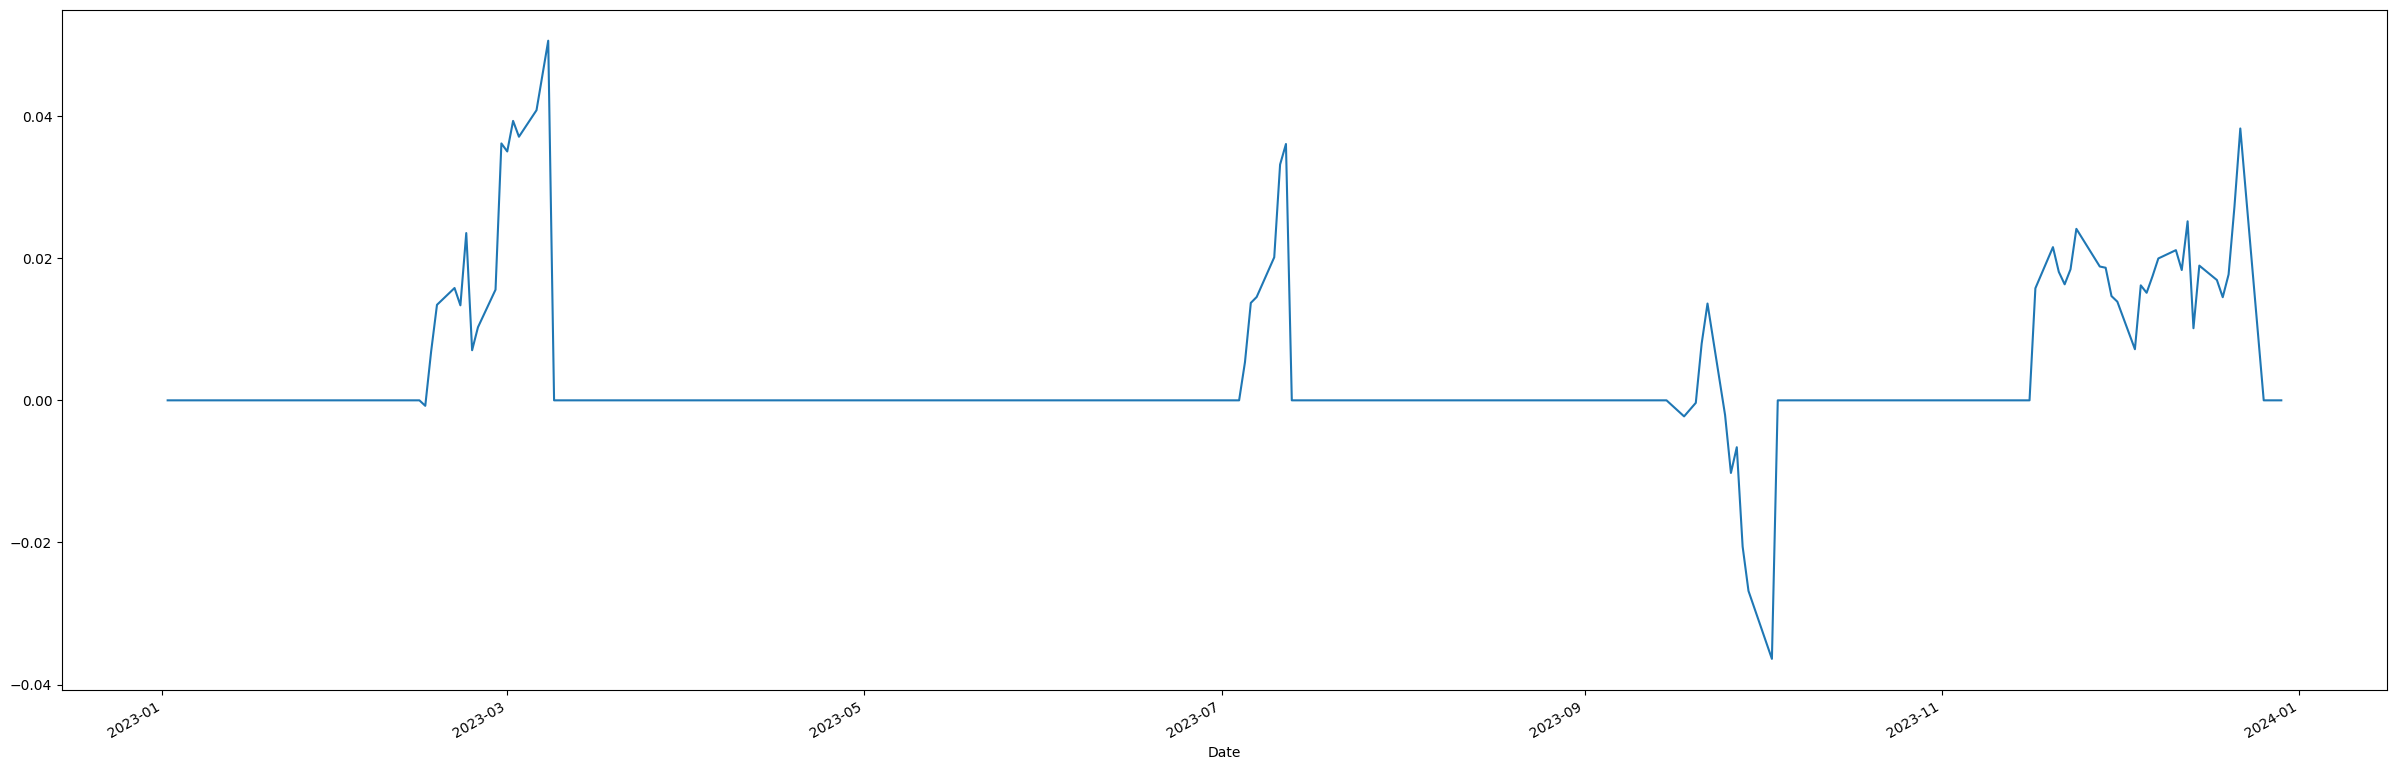

In [ ]:
stats['net_pnl_perc'].plot(figsize=(30, 10))

<Axes: xlabel='Date'>

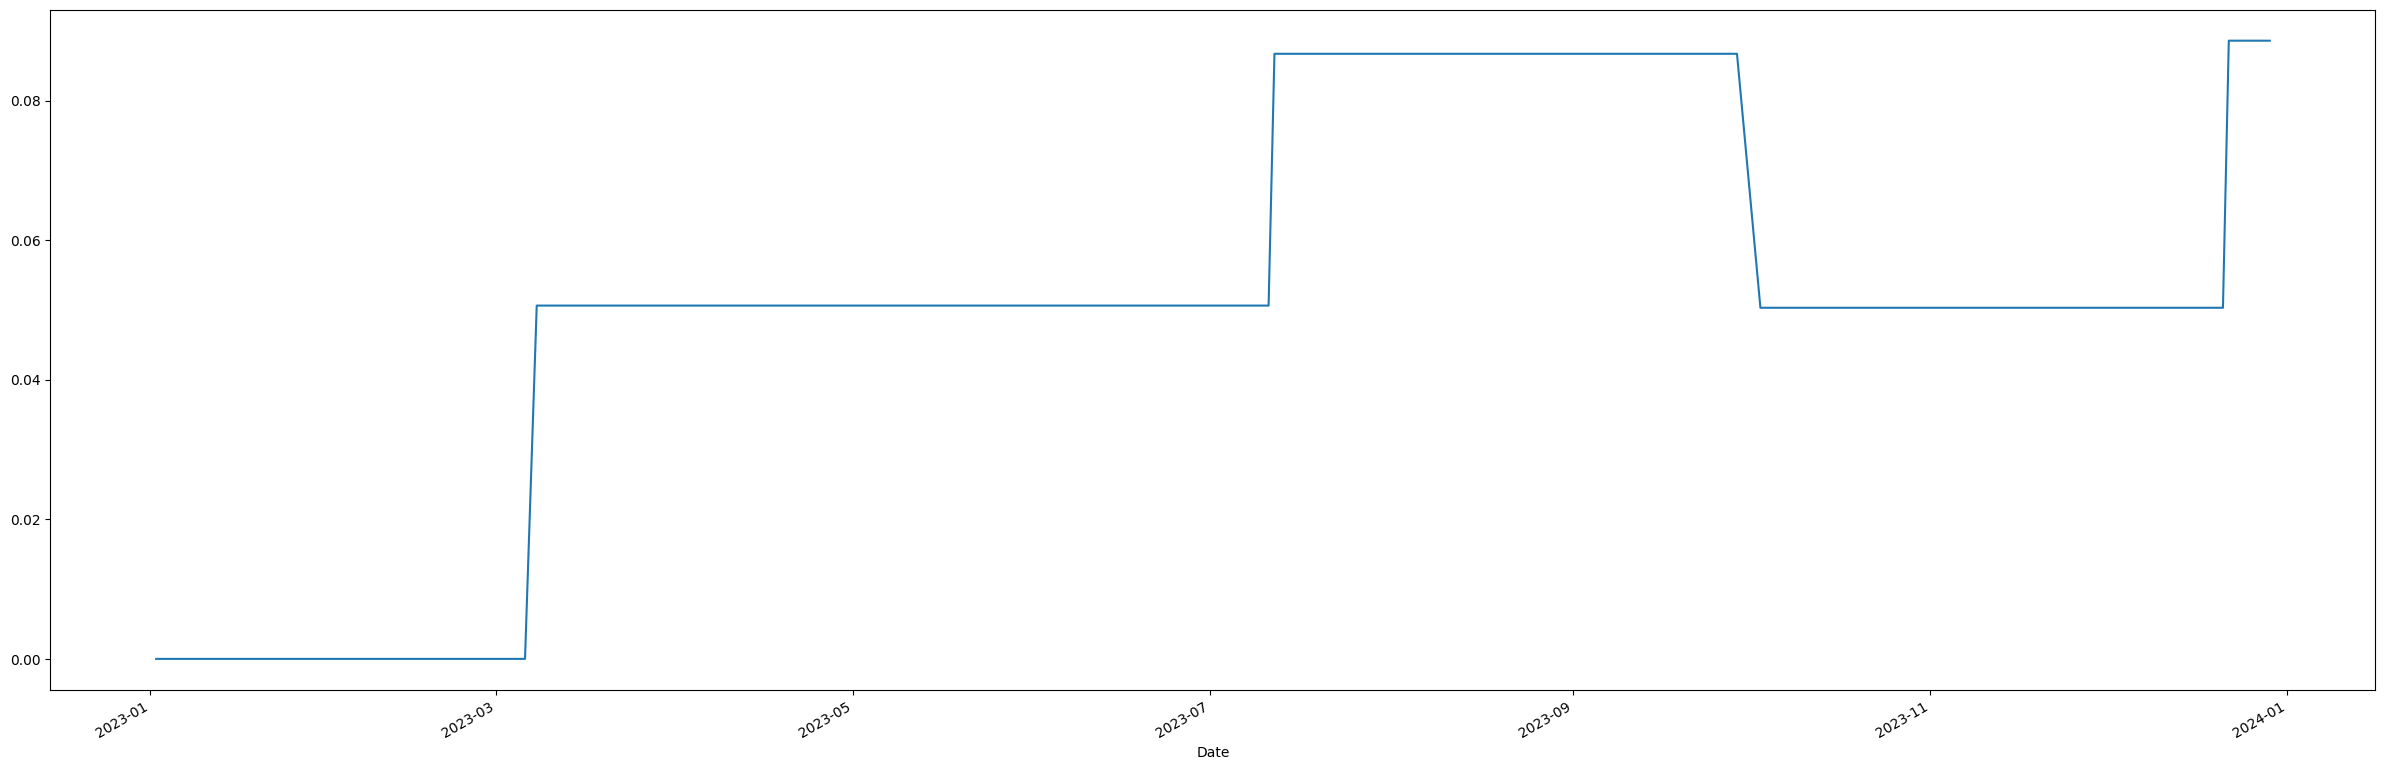

In [ ]:
stats['realised_return'].plot(figsize=(30, 10))

In [ ]:
stats[['net_pnl_perc', 'realised_return']]

,net_pnl_perc,realised_return
Date,,
2023-01-02,0.000000,0.000000
2023-01-03,0.000000,0.000000
2023-01-04,0.000000,0.000000
2023-01-05,0.000000,0.000000
2023-01-06,0.000000,0.000000
...,...,...
2023-12-22,0.038263,0.088569
2023-12-26,0.000000,0.088569
2023-12-27,0.000000,0.088569


In [ ]:
stats

,ASIANPAINT,BAJFINANCE,current_residual,date,previous_residual,residual_mean,residual_std,res_overval_cutoff,res_underval_cutoff,res_overval_stoploss,res_underval_stoploss,realised_return,signal,long_pnl_perc,short_pnl_perc,net_pnl_perc
Date,,,,,,,,,,,,,,,,
2023-01-02,3047.250000,6553.750000,-29.556081,2023-01-02,NaN,-7.906935e-12,495.124769,495.124769,-495.124769,990.249537,-990.249537,0.000000,NaN,NaN,NaN,0.000000
2023-01-03,3028.250000,6606.250000,70.077517,2023-01-03,-29.556081,-7.906935e-12,495.124769,495.124769,-495.124769,990.249537,-990.249537,0.000000,NaN,NaN,NaN,0.000000
2023-01-04,3016.850098,6571.000000,63.107434,2023-01-04,70.077517,-7.906935e-12,495.124769,495.124769,-495.124769,990.249537,-990.249537,0.000000,NaN,NaN,NaN,0.000000
2023-01-05,3004.350098,6100.049805,-376.833815,2023-01-05,63.107434,-7.906935e-12,495.124769,495.124769,-495.124769,990.249537,-990.249537,0.000000,NaN,NaN,NaN,0.000000
2023-01-06,2978.399902,5980.399902,-432.108661,2023-01-06,-376.833815,-7.906935e-12,495.124769,495.124769,-495.124769,990.249537,-990.249537,0.000000,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,3341.300049,7295.299805,-17.460847,2023-12-22,149.524940,-7.906935e-12,495.124769,495.124769,-495.124769,990.249537,-990.249537,0.088569,exit overval: target,0.067406,0.009121,0.038263
2023-12-26,3383.350098,7162.299805,-254.775063,2023-12-26,-17.460847,-7.906935e-12,495.124769,495.124769,-495.124769,990.249537,-990.249537,0.088569,NaN,NaN,NaN,0.000000
2023-12-27,3404.449951,7232.799805,-236.617800,2023-12-27,-254.775063,-7.906935e-12,495.124769,495.124769,-495.124769,990.249537,-990.249537,0.088569,NaN,NaN,NaN,0.000000


In [ ]:
ALL_TRADES

,pair,residual_state,entry_date,short_ticker,long_ticker,short_entry_price,long_entry_price,long_ticker_wt,short_ticker_wt,exit_date,short_exit_price,long_exit_price,exit_reason
0,"(ASIANPAINT, BAJFINANCE)",overval,2023-02-14,BAJFINANCE,ASIANPAINT,6458.700195,2777.000000,0.5,0.5,2023-03-08,5996.850098,2859.550049,target
1,"(ASIANPAINT, BAJFINANCE)",overval,2023-07-04,BAJFINANCE,ASIANPAINT,7860.450195,3347.699951,0.5,0.5,2023-07-12,7431.950195,3406.750000,target
2,"(ASIANPAINT, BAJFINANCE)",overval,2023-09-15,BAJFINANCE,ASIANPAINT,7492.200195,3196.649902,0.5,0.5,2023-10-03,7967.600098,3166.850098,stoploss
3,"(ASIANPAINT, BAJFINANCE)",overval,2023-11-16,BAJFINANCE,ASIANPAINT,7362.450195,3130.300049,0.5,0.5,2023-12-22,7295.299805,3341.300049,target


In [ ]:
# stats['realised_return'] = stats['realised_return'].ffill()

In [ ]:
stats['total_return'] = stats['realised_return'] + stats['net_pnl_perc']

<Axes: xlabel='Date'>

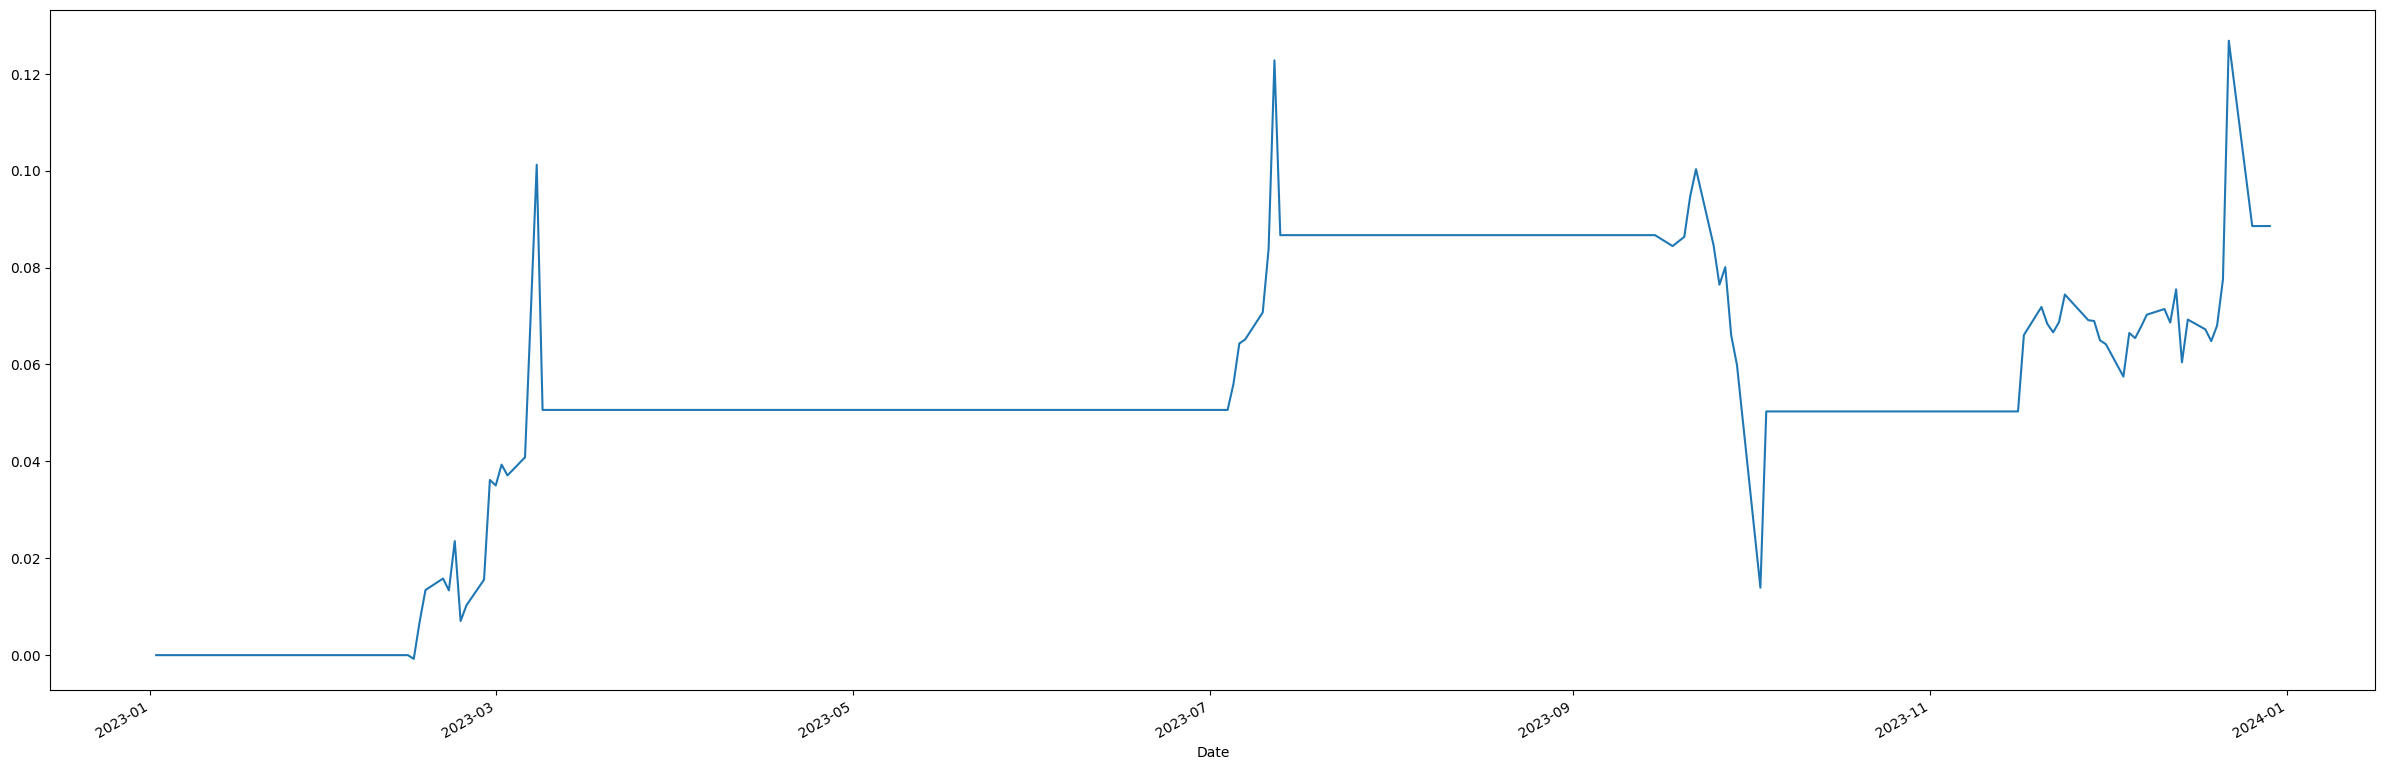

In [ ]:
stats['total_return'].plot(figsize=(30, 10))

<Axes: xlabel='Date'>

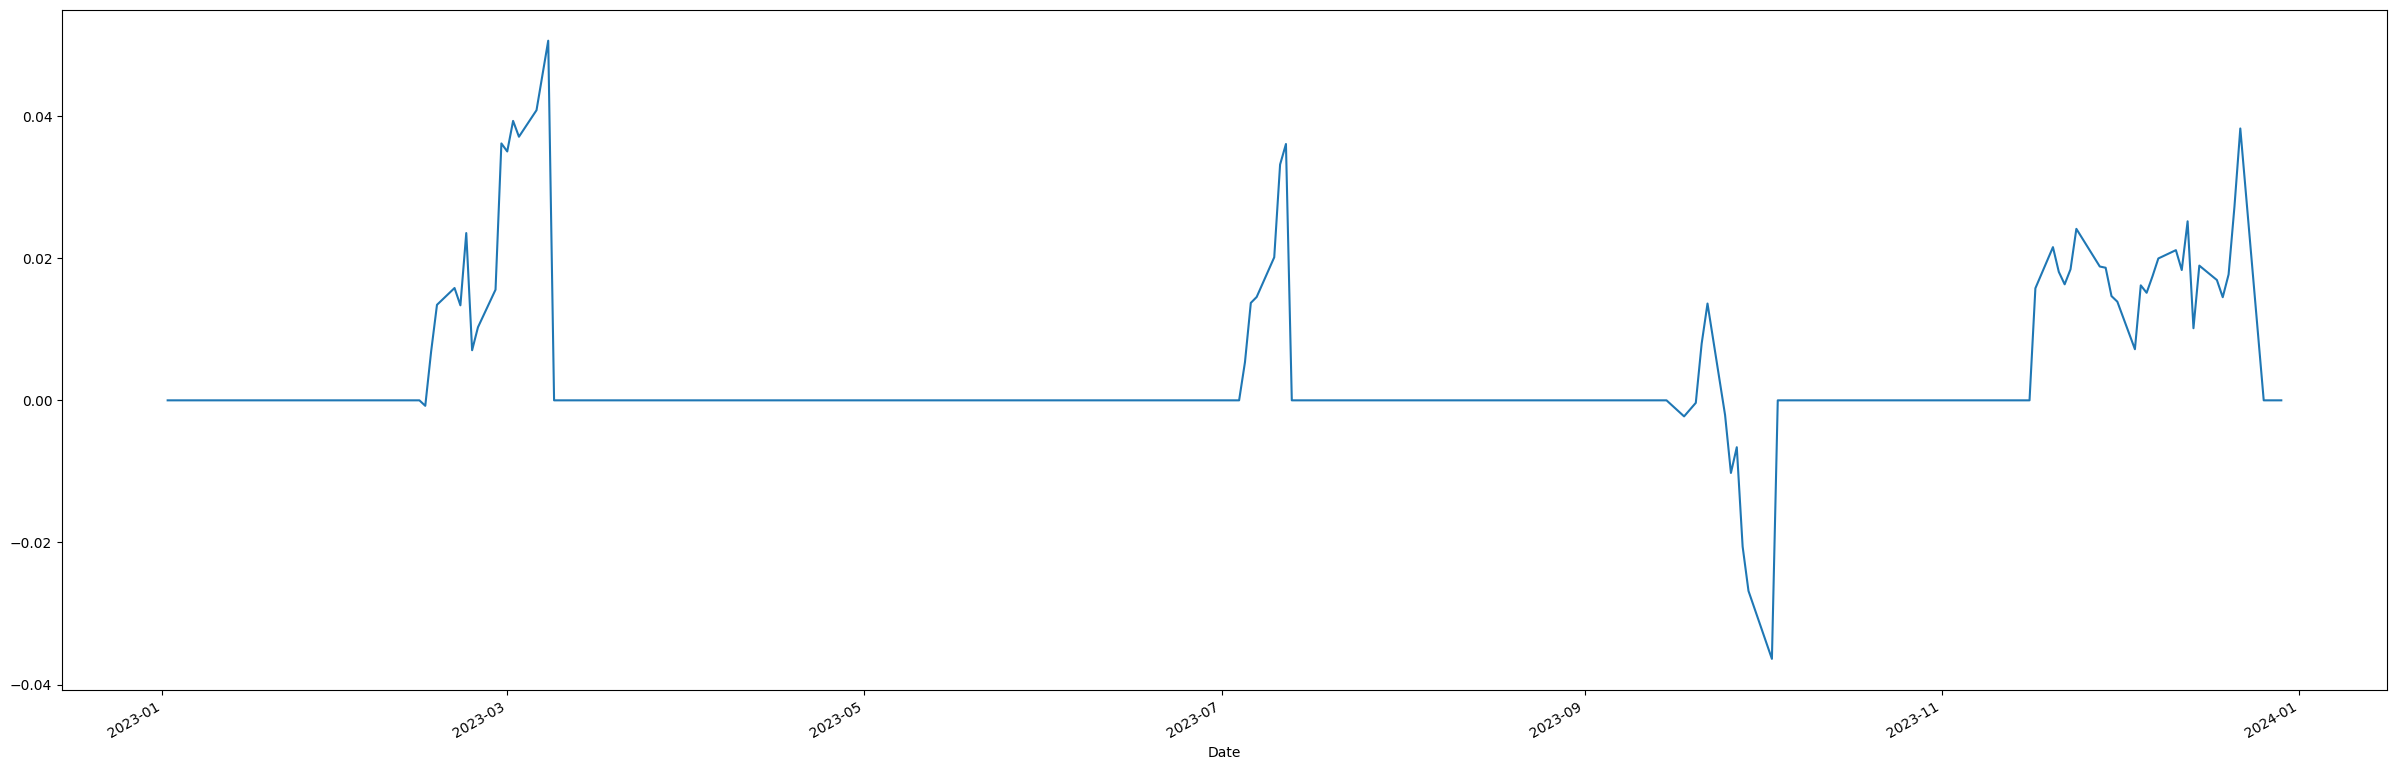

In [ ]:
stats['net_pnl_perc'].plot(figsize=(30, 10))